# Instal libraries

In [1]:
pip install rasterio pyproj

Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [2]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import config # Import the configuration file
from shapely.ops import nearest_points
from shapely.geometry import Point
from sklearn.metrics import mean_squared_error
from math import sqrt

importlib.reload(config)

# Confusion Matrix

In [3]:
def compute_metrics(tp, fp, tn, fn):
    """
    Compute evaluation metrics for flood model validation.

    Parameters
    ----------
    tp : int
        Number of true positives.
    fp : int
        Number of false positives.
    tn : int
        Number of true negatives.
    fn : int
        Number of false negatives.

    Returns
    -------
    precision : float
        Precision score.
    recall : float
        Recall score.
    specificity : float
        Specificity score.
    f1 : float
        F1 score.
    fdr : float
        False Discovery Rate (FDR).

    Examples
    --------
    >>> tp, fp, tn, fn = 100, 10, 80, 20
    >>> precision, recall, specificity, f1, fdr = compute_metrics(tp, fp, tn, fn)
    >>> print("Precision:", precision)
    >>> print("Recall:", recall)
    >>> print("Specificity:", specificity)
    >>> print("F1 Score:", f1)
    >>> print("FDR:", fdr)
    """
    precision = tp / (tp + fp) if (tp + fp) != 0 else float('nan')
    recall = tp / (tp + fn) if (tp + fn) != 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) != 0 else float('nan')
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else float('nan')
    fdr = fp / (fp + tp) if (fp + tp) != 0 else float('nan')
    
    return precision, recall, specificity, f1, fdr

In [4]:
def read_raster_data(raster_path):
    """
    Reads raster data from a file and provides statistics about the data.

    Parameters
    ----------
    raster_path : str
        Path to the raster file.

    Returns
    -------
    lon_flat : numpy.ndarray
        Flattened array of longitude coordinates.
    lat_flat : numpy.ndarray
        Flattened array of latitude coordinates.
    elevation_flat : numpy.ndarray
        Flattened array of elevation data.
    positive_count : int
        Count of positive elevation values.
    nan_count : int
        Count of NaN values in the elevation data.

    Examples
    --------
    >>> lon_flat, lat_flat, elevation_flat, positive_count, nan_count = read_raster_data('FDR_PreCCFM_thr_1m.tif')
    >>> print(f"Positive values: {positive_count}, NaN values: {nan_count}")
    """
    with rasterio.open(raster_path) as dataset:
        # Read the elevation data assuming it's in the first band
        elevation = dataset.read(1)
        
        # Replace 0 values with np.nan for consistent handling
        elevation[elevation == 0] = np.nan

        # Generate arrays for longitude and latitude coordinates
        cols, rows = np.meshgrid(np.arange(elevation.shape[1]), np.arange(elevation.shape[0]))
        # Transform coordinates using the dataset's affine transformation
        lon, lat = rasterio.transform.xy(dataset.transform, rows, cols, offset='center')
        
        # Flatten the arrays for easy handling
        lon_flat = np.array(lon).flatten()
        lat_flat = np.array(lat).flatten()
        elevation_flat = elevation.flatten()
        
        # Count positive values
        positive_count = np.sum(elevation_flat > 0)
        # Count NaN values (which now include original NoData values)
        nan_count = np.sum(np.isnan(elevation_flat))
        
        return lon_flat, lat_flat, elevation_flat, positive_count, nan_count

# File paths for your rasters using the paths specified in config.py
file_paths = {
    'SFINCS': config.SFINCS,               # Path for the SFINCS model output raster
    'PreCCFM': config.PreCCFM,             # Path for the Pre-Calibration Coastal Flood Map raster
    'PostCCFM': config.PostCCFM            # Path for the Post-Calibration Coastal Flood Map raster
}

# Process each raster and store the results
raster_data = {key: read_raster_data(path) for key, path in file_paths.items()}

# Print out the positive and NaN counts for each raster
for key, (_, _, _, positive_count, nan_count) in raster_data.items():
    print(f"{key}: {positive_count} positive values, {nan_count} NaN values")

SFINCS: 35581982 positive values, 177918018 NaN values
PreCCFM: 35524652 positive values, 177975348 NaN values
PostCCFM: 31841237 positive values, 181658763 NaN values


In [5]:
def compare_against_sfincs(sfincs_data, comp_data):
    """
    Compare SFINCS data against another dataset to compute true/false positives and negatives.

    Parameters
    ----------
    sfincs_data : numpy.ndarray
        Flattened array of SFINCS elevation data.
    comp_data : numpy.ndarray
        Flattened array of comparison elevation data.

    Returns
    -------
    true_positives : int
        Number of true positives.
    false_positives : int
        Number of false positives.
    true_negatives : int
        Number of true negatives.
    false_negatives : int
        Number of false negatives.

    Examples
    --------
    >>> tp, fp, tn, fn = compare_against_sfincs(sfincs_data, comp_data)
    >>> print(f"True Positives: {tp}, False Positives: {fp}, True Negatives: {tn}, False Negatives: {fn}")
    """
    # True Positives: Non-NaN values that match in both datasets
    true_positives = np.sum(~np.isnan(sfincs_data) & ~np.isnan(comp_data))
    
    # False Positives: Non-NaN values in comparison dataset where SFINCS has NaN
    false_positives = np.sum(~np.isnan(comp_data) & np.isnan(sfincs_data))
    
    # True Negatives: NaN values at the same location in both datasets
    true_negatives = np.sum(np.isnan(sfincs_data) & np.isnan(comp_data))
    
    # False Negatives: SFINCS has non-NaN values where the comparison dataset has NaN
    false_negatives = np.sum(np.isnan(comp_data) & ~np.isnan(sfincs_data))
    
    return true_positives, false_positives, true_negatives, false_negatives

def process_and_compare_rasters(file_paths):
    """
    Process raster data from file paths and compare the elevation data.

    Parameters
    ----------
    file_paths : dict
        Dictionary with keys as identifiers and values as file paths to the raster files.

    Returns
    -------
    results : dict
        Dictionary containing comparison results for each pair of datasets.

    Examples
    --------
    >>> file_paths = {
    ...     'SFINCS': 'SFINCS_thr_1m.tif',
    ...     'PreCCFM': 'FDR_PreCCFM_thr_1m.tif',
    ...     'PostCCFM': 'FDR_PostCCFM_thr_1m.tif'
    ... }
    >>> results = process_and_compare_rasters(file_paths)
    >>> for key, result in results.items():
    ...     print(f"{key}: {result}")
    """
    # Read and process each raster
    elevation_data = {key: read_raster_data(path) for key, path in file_paths.items()}

    # Extract the elevation_flat data for comparison
    sfincs_elevation_flat = elevation_data['SFINCS'][2]
    preccfm_elevation_flat = elevation_data['PreCCFM'][2]
    postccfm_elevation_flat = elevation_data['PostCCFM'][2]

    # Perform comparisons
    results = {
        'PreCCFM vs SFINCS': compare_against_sfincs(sfincs_elevation_flat, preccfm_elevation_flat),
        'PostCCFM vs SFINCS': compare_against_sfincs(sfincs_elevation_flat, postccfm_elevation_flat)
    }

    # Print results
    for key, (tp, fp, tn, fn) in results.items():
        print(f"\nComparison for {key}:")
        print(f"True Positives: {tp}")
        print(f"False Positives: {fp}")
        print(f"True Negatives: {tn}")
        print(f"False Negatives: {fn}")

    return results

# File paths for your rasters using the paths specified in config.py
file_paths = {
    'SFINCS': config.SFINCS,               # Path for the SFINCS model output raster
    'PreCCFM': config.PreCCFM,             # Path for the Pre-Calibration Coastal Flood Map raster
    'PostCCFM': config.PostCCFM            # Path for the Post-Calibration Coastal Flood Map raster
}

# Process and compare rasters
results = process_and_compare_rasters(file_paths)


Comparison for PreCCFM vs SFINCS:
True Positives: 30010137
False Positives: 5514515
True Negatives: 172403503
False Negatives: 5571845

Comparison for PostCCFM vs SFINCS:
True Positives: 27913347
False Positives: 3927890
True Negatives: 173990128
False Negatives: 7668635


In [6]:
def process_and_compare_rasters(file_paths):
    """
    Process raster data from file paths, compare the elevation data, and compute metrics.

    Parameters
    ----------
    file_paths : dict
        Dictionary with keys as identifiers and values as file paths to the raster files.

    Returns
    -------
    results : dict
        Dictionary containing comparison results and metrics for each pair of datasets.

    Examples
    --------
    >>> file_paths = {
    ...     'SFINCS': 'SFINCS_thr_1m.tif',
    ...     'PreCCFM': 'FDR_PreCCFM_thr_1m',
    ...     'PostCCFM': 'FDR_PostCCFM_thr_1m.tif'
    ... }
    >>> results = process_and_compare_rasters(file_paths)
    >>> for key, result in results.items():
    ...     print(f"{key}: {result}")
    """
    # Read and process each raster
    elevation_data = {key: read_raster_data(path) for key, path in file_paths.items()}

    # Extract the elevation_flat data for comparison
    sfincs_elevation_flat = elevation_data['SFINCS'][2]
    preccfm_elevation_flat = elevation_data['PreCCFM'][2]
    postccfm_elevation_flat = elevation_data['PostCCFM'][2]

    # Perform comparisons and compute metrics
    comparisons = {
        'PreCCFM vs SFINCS': compare_against_sfincs(sfincs_elevation_flat, preccfm_elevation_flat),
        'PostCCFM vs SFINCS': compare_against_sfincs(sfincs_elevation_flat, postccfm_elevation_flat)
    }

    metrics_results = {}
    for key, (tp, fp, tn, fn) in comparisons.items():
        metrics_results[key] = compute_metrics(tp, fp, tn, fn)
    
    # Print results
    for key, (precision, recall, specificity, f1, fdr) in metrics_results.items():
        print(f"\nMetrics for {key}:")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"Specificity: {specificity}")
        print(f"F1 Score: {f1}")
        print(f"FDR: {fdr}")

    return metrics_results

In [7]:
def export_classification_raster(sfincs_data, comp_data, raster_template_path, export_path):
    """
    Export a classification raster based on the comparison of SFINCS data and another dataset.

    Parameters
    ----------
    sfincs_data : numpy.ndarray
        Flattened array of SFINCS elevation data.
    comp_data : numpy.ndarray
        Flattened array of comparison elevation data.
    raster_template_path : str
        Path to the template raster file to obtain the original shape and metadata.
    export_path : str
        Path to save the exported classification raster.

    Returns
    -------
    None

    Examples
    --------
    >>> sfincs_data = np.random.rand(10000)
    >>> comp_data = np.random.rand(10000)
    >>> export_classification_raster(sfincs_data, comp_data, 'template_raster.tif', 'classification_raster.tif')
    """
    # First, find the original shape by reading the template raster
    with rasterio.open(raster_template_path) as src:
        original_shape = src.shape  # This gives you the (height, width)

    # Categorize each cell based on comparison, keeping the flat structure for now
    categories_flat = np.full_like(sfincs_data, -1, dtype=np.int8)  # Initialize with NoData value
    categories_flat[(~np.isnan(sfincs_data) & ~np.isnan(comp_data))] = 1  # True Positives
    categories_flat[(~np.isnan(comp_data) & np.isnan(sfincs_data))] = 2  # False Positives
    categories_flat[(np.isnan(sfincs_data) & np.isnan(comp_data))] = 3  # True Negatives
    categories_flat[(np.isnan(comp_data) & ~np.isnan(sfincs_data))] = 4  # False Negatives

    # Reshape the flat categories array back into the original raster dimensions
    categories = categories_flat.reshape(original_shape)

    # Proceed to write this 2D array into the new raster as before
    with rasterio.open(raster_template_path) as src:
        meta = src.meta.copy()
    meta.update(count=1, dtype=rasterio.int8)

    with rasterio.open(export_path, 'w', **meta) as dst:
        dst.write(categories, 1)

In [8]:
# Example usage:
# File paths for your rasters using the paths specified in config.py
file_paths = {
    'SFINCS': config.SFINCS,               # Path for the SFINCS model output raster
    'PreCCFM': config.PreCCFM,             # Path for the Pre-Calibration Coastal Flood Map raster
    'PostCCFM': config.PostCCFM            # Path for the Post-Calibration Coastal Flood Map raster
}

# Process and compare rasters
results = process_and_compare_rasters(file_paths)

# Example export paths for classification rasters
export_paths = {
    'PreCCFM vs SFINCS': 'classification_PreCCFM_vs_SFINCS.tif',
    'PostCCFM vs SFINCS': 'classification_PostCCFM_vs_SFINCS.tif'
}

# Export classification rasters based on comparisons
sfincs_elevation_flat = read_raster_data(file_paths['SFINCS'])[2]
preccfm_elevation_flat = read_raster_data(file_paths['PreCCFM'])[2]
postccfm_elevation_flat = read_raster_data(file_paths['PostCCFM'])[2]

export_classification_raster(sfincs_elevation_flat, preccfm_elevation_flat, file_paths['SFINCS'], export_paths['PreCCFM vs SFINCS'])
export_classification_raster(sfincs_elevation_flat, postccfm_elevation_flat, file_paths['SFINCS'], export_paths['PostCCFM vs SFINCS'])


Metrics for PreCCFM vs SFINCS:
Precision: 0.8447693449607895
Recall: 0.8434082452180433
Specificity: 0.9690053033302113
F1 Score: 0.8440882463934377
FDR: 0.15523065503921052

Metrics for PostCCFM vs SFINCS:
Precision: 0.8766414131461036
Recall: 0.784479824648329
Specificity: 0.9779230341920738
F1 Score: 0.8280039847993611
FDR: 0.1233585868538964


C:\Users\as229858\AppData\Local\Temp\ipykernel_104244\277832934.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', 5)  # 5 discrete colors


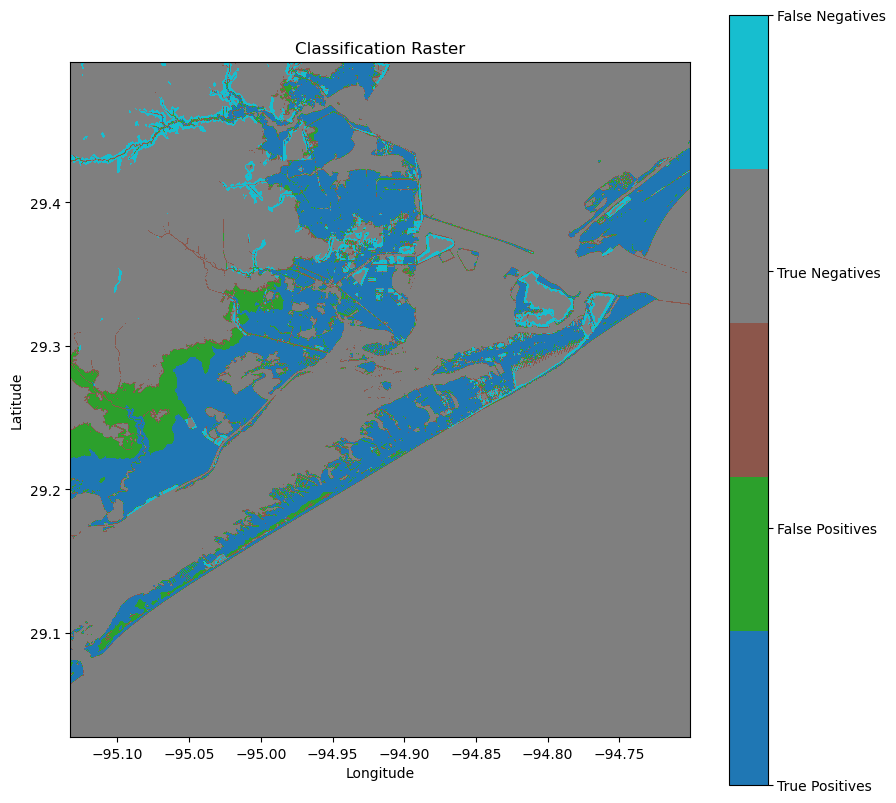

C:\Users\as229858\AppData\Local\Temp\ipykernel_104244\277832934.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', 5)  # 5 discrete colors


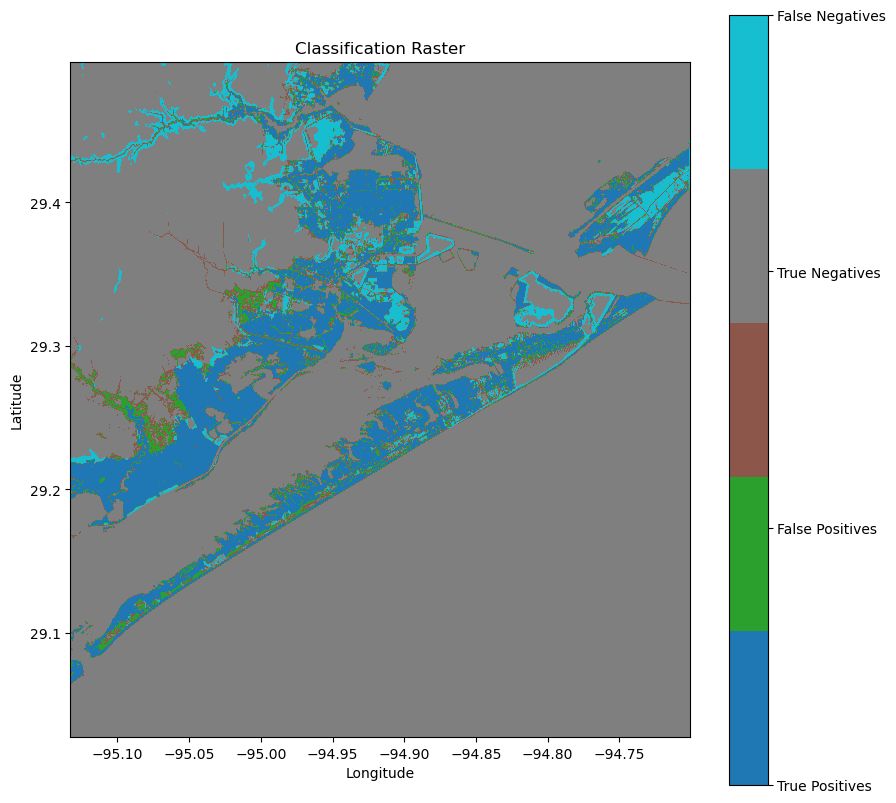

In [9]:
def visualize_classification_raster(raster_path):
    """
    Visualize the classification raster.

    Parameters
    ----------
    raster_path : str
        Path to the classification raster file.

    Returns
    -------
    None

    Examples
    --------
    >>> visualize_classification_raster('classification_PreCCFM_vs_SFINCS.tif')
    """
    with rasterio.open(raster_path) as dataset:
        # Read the classification data assuming it's in the first band
        classification = dataset.read(1)
        transform = dataset.transform

    # Define a colormap for the classification categories
    cmap = plt.cm.get_cmap('tab10', 5)  # 5 discrete colors

    # Plot the classification raster
    plt.figure(figsize=(10, 10))
    plt.imshow(classification, cmap=cmap, extent=(transform[2], transform[2] + transform[0] * classification.shape[1], transform[5] + transform[4] * classification.shape[0], transform[5]))
    cbar = plt.colorbar(ticks=[-1, 1, 2, 3, 4])
    cbar.ax.set_yticklabels(['NoData', 'True Positives', 'False Positives', 'True Negatives', 'False Negatives'])
    plt.title('Classification Raster')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Example usage
visualize_classification_raster('classification_PreCCFM_vs_SFINCS.tif')
visualize_classification_raster('classification_PostCCFM_vs_SFINCS.tif')

# Root Mean Squared Error Based on SFINCS vs High Water Marks

In [9]:
import geopandas as gpd
import numpy as np
import rasterio
from shapely.ops import nearest_points
from sklearn.metrics import mean_squared_error
from math import sqrt

def read_shapefile(shapefile_path):
    """
    Load a shapefile using GeoPandas.

    Parameters
    ----------
    shapefile_path : str
        Path to the shapefile.

    Returns
    -------
    shapefile_gdf : GeoDataFrame
        GeoDataFrame containing the shapefile data.

    Examples
    --------
    >>> shapefile_gdf = read_shapefile("HWM_IKE_ORG.shp")
    >>> print(shapefile_gdf.head())
    """
    print(f"Loading shapefile from {shapefile_path}")
    shapefile_gdf = gpd.read_file(shapefile_path)
    print(f"Loaded shapefile with {len(shapefile_gdf)} points")
    return shapefile_gdf

def extract_raster_values(raster_path, shapefile_gdf):
    """
    Extract raster values based on the coordinates of shapefile points.

    Parameters
    ----------
    raster_path : str
        Path to the raster file.
    shapefile_gdf : GeoDataFrame
        GeoDataFrame containing the shapefile data.

    Returns
    -------
    z_values : list
        List of raster values extracted at the points defined in the shapefile.

    Examples
    --------
    >>> z_values = extract_raster_values('SFINCS_FILT.tif', shapefile_gdf)
    >>> print(z_values[:5])
    """
    print(f"Extracting raster values from {raster_path}")
    try:
        with rasterio.open(raster_path) as src:
            coordinates = [(point.x, point.y) for point in shapefile_gdf.geometry]
            z_values = []
            for coord in coordinates:
                try:
                    z_value = src.sample([coord]).__next__()[0]
                except Exception as e:
                    print(f"Error reading value at {coord}: {e}")
                    z_value = np.nan
                z_values.append(z_value)
        print(f"Extracted {len(z_values)} values from {raster_path}")
    except Exception as e:
        print(f"Error opening raster file {raster_path}: {e}")
        z_values = [np.nan] * len(shapefile_gdf)
    return z_values

def calculate_rmse_and_print_values(reference_values, comparison_values, file_name, print_count=5):
    """
    Calculate RMSE and print sample comparison values between reference and comparison datasets.

    Parameters
    ----------
    reference_values : list
        List of reference z values.
    comparison_values : list
        List of comparison z values.
    file_name : str
        Name of the file being compared.
    print_count : int, optional
        Number of sample values to print (default is 5).

    Returns
    -------
    rmse : float
        Root Mean Squared Error between the reference and comparison values.
    valid_points : int
        Number of valid points used in the calculation.

    Examples
    --------
    >>> rmse, valid_points = calculate_rmse_and_print_values(ref_values, comp_values, 'SFINCS_FILT.tif')
    >>> print(f"RMSE: {rmse}, Valid Points: {valid_points}")
    """
    print(f"Calculating RMSE for {file_name}")
    # Filter out pairs with NaN in either reference or comparison
    mask = ~np.isnan(reference_values) & ~np.isnan(comparison_values)
    filtered_ref_values = np.array(reference_values)[mask]
    filtered_comp_values = np.array(comparison_values)[mask]

    # Print the first few valid z values for comparison
    print(f"\n{file_name}:")
    print("Reference z values | Compared z values")
    for i in range(min(print_count, len(filtered_ref_values))):
        print(f"{filtered_ref_values[i]:.3f} | {filtered_comp_values[i]:.3f}")

    # Calculate RMSE
    rmse = sqrt(mean_squared_error(filtered_ref_values, filtered_comp_values))
    return rmse, len(filtered_ref_values)

def save_extracted_data_as_shapefile(shapefile_gdf, z_values, filename):
    """
    Save the extracted raster values as a new shapefile.

    Parameters
    ----------
    shapefile_gdf : GeoDataFrame
        GeoDataFrame containing the original shapefile data.
    z_values : list
        List of extracted raster values to add to the GeoDataFrame.
    filename : str
        Path to save the new shapefile.

    Returns
    -------
    None

    Examples
    --------
    >>> save_extracted_data_as_shapefile(shapefile_gdf, z_values, 'extracted_data.shp')
    """
    print(f"Saving extracted data to {filename}")
    gdf = shapefile_gdf.copy()
    gdf['z_value'] = z_values
    gdf.to_file(filename, driver='ESRI Shapefile')
    print(f"Saved shapefile to {filename}")

def main():
    # Path to the shapefile
    shapefile_path = "HWM_IKE_ORG.shp"

    # List of raster files for comparison against HWMs using paths specified in config.py
    raster_files = [
    config.sfincc_thr_or       # Path for the SFINCS model threshold raster
    ]

    # Load the shapefile
    shapefile_gdf = read_shapefile(shapefile_path)

    # Extract data for all rasters
    extracted_data = {file: extract_raster_values(file, shapefile_gdf) for file in raster_files}

    # Assuming shapefile_gdf has a 'z' column with reference z values
    shapefile_z_values = shapefile_gdf['z'].tolist()

    # Calculate RMSE for each raster, excluding NaN values, print first few z values, and store the results
    rmse_results = {}
    for file, z_values in extracted_data.items():
        rmse, valid_points = calculate_rmse_and_print_values(shapefile_z_values, z_values, file)
        rmse_results[file] = rmse
        print(f"RMSE for {file}: {rmse}, based on {valid_points} valid comparisons.\n")

    # Save extracted data for each raster
    for file, z_values in extracted_data.items():
        new_filename = file.replace(".tif", "_extracted.shp")
        save_extracted_data_as_shapefile(shapefile_gdf, z_values, new_filename)

if __name__ == "__main__":
    main()

Loading shapefile from HWM_IKE_ORG.shp
Loaded shapefile with 35 points
Extracting raster values from SFINCS_0_3048_thr_or.tif
Extracted 35 values from SFINCS_0_3048_thr_or.tif
Calculating RMSE for SFINCS_0_3048_thr_or.tif

SFINCS_0_3048_thr_or.tif:
Reference z values | Compared z values
2.957 | 0.928
3.261 | 0.875
3.139 | 1.022
2.408 | 1.091
2.865 | 1.026
RMSE for SFINCS_0_3048_thr_or.tif: 1.9192164047068407, based on 35 valid comparisons.

Saving extracted data to SFINCS_0_3048_thr_or_extracted.shp
Saved shapefile to SFINCS_0_3048_thr_or_extracted.shp
